In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import warnings
warnings.filterwarnings("ignore") 
import scipy.stats as st
from patsy import dmatrix, dmatrices
from more_itertools import ncycles

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### 10.2 Data Generation

In [2]:
np.random.seed(73)
# Choose sample size
n_pop = 5
n_elev = 3
nsample = 12
n = n_pop * nsample

# Create factor levels
pop = np.repeat(np.arange(1, n_pop+1), nsample)
elev = list(ncycles(np.repeat(np.arange(1, n_elev+1), nsample / n_elev), int(n / nsample)))

# Choose effects
baseline = 40
pop_effects = [-10, -5, 5, 10]
elev_effects = [5, 10]
interaction_effects = [-2, 3, 0, 4, 4, 0, 3, -2]
all_effects = [baseline, *pop_effects, *elev_effects, *interaction_effects]

sigma = 3
eps = st.norm.rvs(0, sigma, size = n)

data_ds = pd.DataFrame({'pop': pd.Series(pop, dtype = 'category'), 
                        'elev': pd.Series(elev, dtype = 'category')})
X = dmatrix('~ pop * elev', data_ds, return_type = 'dataframe').to_numpy()
wing = X @ all_effects + eps
data = pd.DataFrame({'wing': wing, 
                     'pop': pd.Series(pop, dtype = 'category'), 
                     'elev': pd.Series(elev, dtype = 'category')})

**FIGURE 10.2**

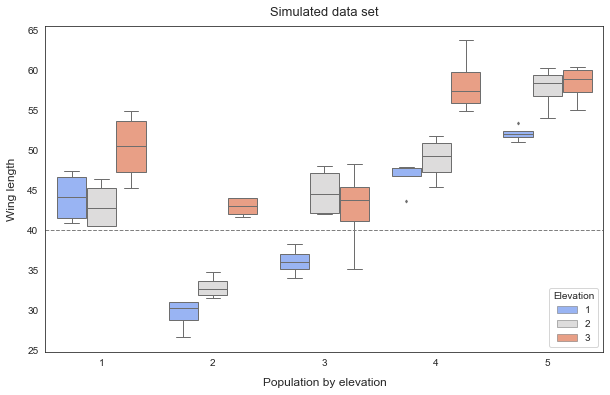

In [3]:
sns.set_style(style = 'white')
plt.figure(figsize = (10,6))
g = sns.boxplot(x = pop, y = wing, hue = elev, palette = 'coolwarm', fliersize = 2, linewidth = 1, saturation = 0.8)
plt.title('Simulated data set', pad = 10, fontsize = 13)
plt.xlabel('Population by elevation', labelpad = 10, fontsize = 12)
plt.ylabel('Wing length', labelpad = 10, fontsize = 12)
g.legend(title = 'Elevation', loc = 'lower right')
plt.axhline(40, 0, 5, lw = 1, ls = '--', color = 'gray');

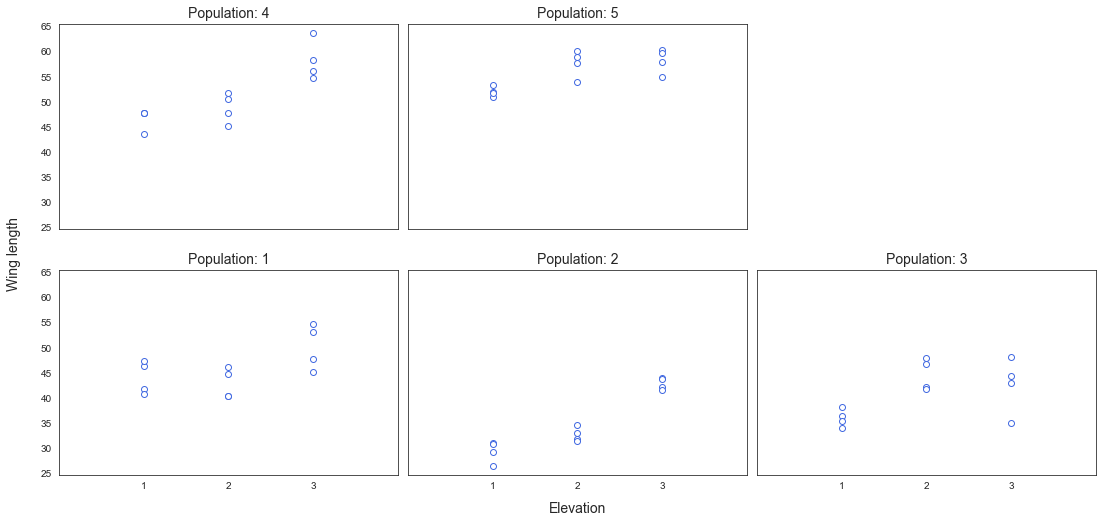

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7.5), sharey=True, sharex=True)
fig.subplots_adjust(left=0.075, right=0.975, bottom=0.09, top=0.925, wspace=0.03)

axes_flat = axes.ravel()

for i, pop_plot in enumerate([4, 5, 6, 1, 2, 3]):
    ax = axes_flat[i]
    idx = data.index[data["pop"] == pop_plot].tolist()
    elev_plot = data.loc[idx, "elev"].values
    wing_plot = data.loc[idx, "wing"].values
 
    # Plot observed data points
    ax.scatter(elev_plot, wing_plot, color="white", ec="royalblue")
    ax.set_xlim(0, 4)
    # Add a title
    ax.set_title(f"Population: {pop_plot}", fontsize=14)

ax.xaxis.set_ticks([1, 2, 3])
fig.delaxes(axes[0][2])
fig.text(0.5, 0.02, "Elevation", fontsize=14)
fig.text(0.03, 0.5, "Wing length", rotation=90, fontsize=14, va="center");

### 10.5 Analysis using PyMC3

#### 10.5.1 Main-effects ANOVA Using PyMC3

In [5]:
idx_pop = pd.Categorical(pop).codes
groups_pop = len(np.unique(idx_pop))
idx_elev = pd.Categorical(elev).codes
groups_elev = len(np.unique(idx_elev))

In [6]:
Y, X = dmatrices('wing ~ pop + elev', data, return_type = 'dataframe')
X = X.rename(columns = {'pop[T.2]': 'pop2', 'pop[T.3]': 'pop3', 'pop[T.4]': 'pop4', 'pop[T.5]': 'pop5', 'elev[T.2]': 'elev2', 'elev[T.3]': 'elev3'})

In [7]:
with pm.Model() as anova_2w:
    
    alpha = pm.Normal('alpha', 0, tau = 0.001)
    beta_pop2 = pm.Normal('beta_pop2', 0, tau = 0.001)
    beta_pop3 = pm.Normal('beta_pop3', 0, tau = 0.001)
    beta_pop4 = pm.Normal('beta_pop4', 0, tau = 0.001)
    beta_pop5 = pm.Normal('beta_pop5', 0, tau = 0.001)
    beta_elev2 = pm.Normal('beta_elev2', 0, tau = 0.001)
    beta_elev3 = pm.Normal('beta_elev3', 0, tau = 0.001)
    
    sigma = pm.Uniform('sigma', 0, 100)
    
    mu = alpha + beta_pop2*X['pop2'] + beta_pop3*X['pop3'] + beta_pop4*X['pop4'] + beta_pop5*X['pop5'] + beta_elev2*X['elev2'] + beta_elev3*X['elev3']
    wing_new = pm.Normal('wing_p', mu = mu, sigma = sigma, observed = wing)
    trace_2w = pm.sample(return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_elev3, beta_elev2, beta_pop5, beta_pop4, beta_pop3, beta_pop2, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


In [8]:
az.summary(trace_2w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,41.473,1.293,38.970,43.713,0.049,0.035,704.0,926.0,1.01
beta_pop2,-10.650,1.591,-13.556,-7.488,0.052,0.037,929.0,1366.0,1.00
beta_pop3,-4.577,1.550,-7.569,-1.618,0.048,0.034,1052.0,1215.0,1.00
beta_pop4,5.562,1.549,2.872,8.527,0.051,0.036,933.0,1217.0,1.00
beta_pop5,10.284,1.542,7.516,13.206,0.052,0.037,897.0,1198.0,1.00
beta_elev2,3.797,1.154,1.818,6.150,0.032,0.023,1281.0,1376.0,1.00
beta_elev3,8.842,1.161,6.763,11.035,0.031,0.022,1405.0,1277.0,1.00
sigma,3.698,0.363,3.049,4.376,0.009,0.006,1800.0,1453.0,1.00


#### 10.5.2 Interaction-Effects ANOVA Using PyMC3

In [9]:
with pm.Model() as model_2w2anova:
    mean = pm.Normal('mean', 0, tau = 0.001, shape = [groups_pop, groups_elev])
    sigma = pm.Uniform('sigma', 0, 100)
    
    wing_new = pm.Normal('wing_p', mu = mean[idx_pop, idx_elev], sigma = sigma, observed = wing)
    trace_2w2anova = pm.sample(return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.


In [10]:
az.summary(trace_2w2anova)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mean[0, 0]",43.989,1.554,41.077,46.757,0.024,0.017,4171.0,1274.0,1.0
"mean[0, 1]",42.941,1.602,39.985,46.100,0.026,0.018,3775.0,1554.0,1.0
"mean[0, 2]",50.154,1.560,47.263,53.085,0.028,0.020,3129.0,1381.0,1.0
"mean[1, 0]",29.387,1.556,26.588,32.353,0.027,0.019,3365.0,1511.0,1.0
"mean[1, 1]",32.701,1.514,29.758,35.420,0.024,0.017,3796.0,1399.0,1.0
"mean[1, 2]",42.776,1.452,39.895,45.399,0.024,0.017,3788.0,1393.0,1.0
"mean[2, 0]",35.968,1.580,32.998,38.941,0.024,0.017,4138.0,1709.0,1.0
"mean[2, 1]",44.582,1.480,41.994,47.359,0.025,0.017,3706.0,1203.0,1.0
"mean[2, 2]",42.507,1.510,39.843,45.332,0.026,0.018,3424.0,1646.0,1.0
"mean[3, 0]",46.535,1.553,43.564,49.384,0.026,0.018,3513.0,1611.0,1.0
